In [26]:
# Imports, Loading data, and preprocessing
# Imports
import pandas as pd
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Load data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]
df = pd.read_csv(url, header=None, names=columns, na_values=' ?').dropna()

# Encode categorical features
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Train-test split
X = df.drop('income', axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Smote
def apply_smote(X_train, y_train, seed=42):
    sm = SMOTE(random_state=seed)
    return sm.fit_resample(X_train, y_train)


In [27]:
# Model Training and Evaluation Function
def train_and_evaluate(model, name, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n🧠 {name} Results")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))


In [28]:


# random forest
X_rf, y_rf = apply_smote(X_train, y_train, seed=1)
rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=42)
train_and_evaluate(rf, "Random Forest", X_rf, y_rf)



🧠 Random Forest Results
Accuracy: 0.8478368970661363
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4503
           1       0.69      0.74      0.71      1530

    accuracy                           0.85      6033
   macro avg       0.80      0.81      0.80      6033
weighted avg       0.85      0.85      0.85      6033



In [29]:
# XGBoost
X_xgb, y_xgb = apply_smote(X_train, y_train, seed=2)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=150, max_depth=7, random_state=42)
train_and_evaluate(xgb, "XGBoost", X_xgb, y_xgb)

/home/captainl/miniforge3/envs/ml/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:59:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🧠 XGBoost Results
Accuracy: 0.8612630532073595
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      4503
           1       0.73      0.72      0.72      1530

    accuracy                           0.86      6033
   macro avg       0.82      0.81      0.82      6033
weighted avg       0.86      0.86      0.86      6033



In [30]:
# Gradient Boosting Classifier
X_gbc, y_gbc = apply_smote(X_train, y_train, seed=3)
gbc = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)
train_and_evaluate(gbc, "Gradient Boosting", X_gbc, y_gbc)


🧠 Gradient Boosting Results
Accuracy: 0.8606000331510029
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      4503
           1       0.72      0.74      0.73      1530

    accuracy                           0.86      6033
   macro avg       0.81      0.82      0.82      6033
weighted avg       0.86      0.86      0.86      6033



In [31]:
# LightGBM
X_lgb, y_lgb = apply_smote(X_train, y_train, seed=4)
lgbm = LGBMClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)
train_and_evaluate(lgbm, "LightGBM", X_lgb, y_lgb)


[LightGBM] [Info] Number of positive: 18151, number of negative: 18151
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 36302, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [32]:
# using optuna for hyperparameter tuning(slow and often does not get you the best ranges, but if you're willing to sacrifice a lot of time it could help.)
import optuna
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 600)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)

    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=42
    )

    # Use cross-validation for stability
    score = cross_val_score(model, X_resampled, y_resampled, cv=3, scoring='accuracy').mean()
    return score


# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # Try 30 different combos

# Show best result
print("✅ Best Parameters:", study.best_params)



/home/captainl/miniforge3/envs/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-25 14:59:41,575] A new study created in memory with name: no-name-8ac88c57-40ae-4d80-8a08-b9314c74b434
[W 2025-03-25 14:59:56,201] Trial 0 failed with parameters: {'n_estimators': 238, 'max_depth': 8, 'learning_rate': 0.31506120327051945, 'min_samples_split': 3, 'min_samples_leaf': 16, 'subsample': 0.7285975338774854} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/captainl/miniforge3/envs/ml/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_133914/875284147.py", line 30, in objective
    score = cross_val_score(model, X_resampled, y_resam

KeyboardInterrupt: 

In [33]:
# 📦 Import stacking-related modules
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# ✅ Define base models (level-0)
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('lgb', LGBMClassifier(random_state=42))
]

# ✅ Define meta-model (level-1)
# You can use LogisticRegression for speed or GradientBoosting for power
meta_model = GradientBoostingClassifier(random_state=42)

# ✅ Build Stacking Classifier
stack = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# ✅ Fit the stack on SMOTE-resampled data
stack.fit(X_resampled, y_resampled)

# ✅ Evaluate on untouched test data
y_pred_stack = stack.predict(X_test)
print("📊 Stacked Accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))



/home/captainl/miniforge3/envs/ml/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:00:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[15:00:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[15:00:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[15:00:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[15:00:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[15:00:09] WARNING: /home/co

[LightGBM] [Info] Number of positive: 14520, number of negative: 14521
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 29041, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499983 -> initscore=-0.000069
[LightGBM] [Info] Start training from score -0.000069
[LightGBM] [Info] Number of positive: 14521, number of negative: 14520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 29041, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500017 -> initscore=0.000069
[Li

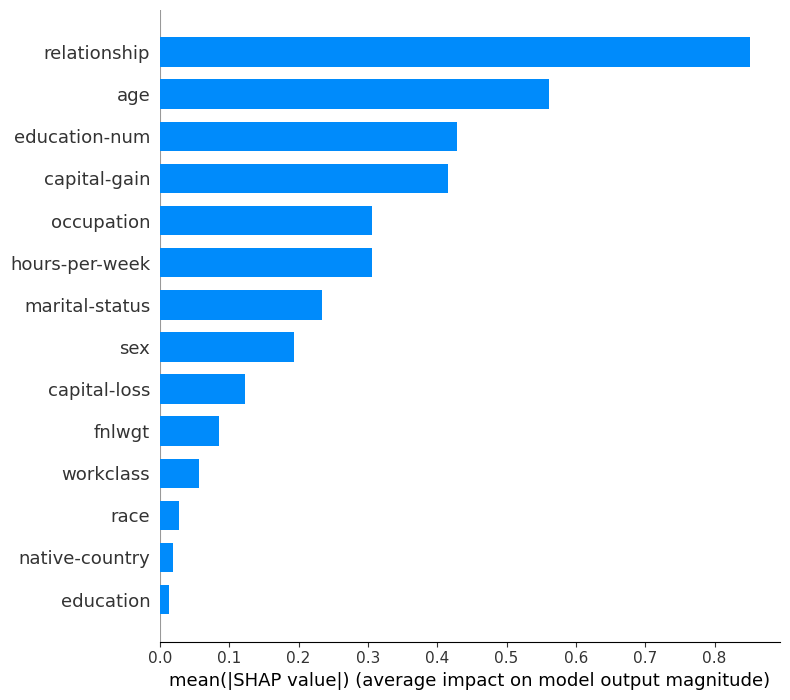

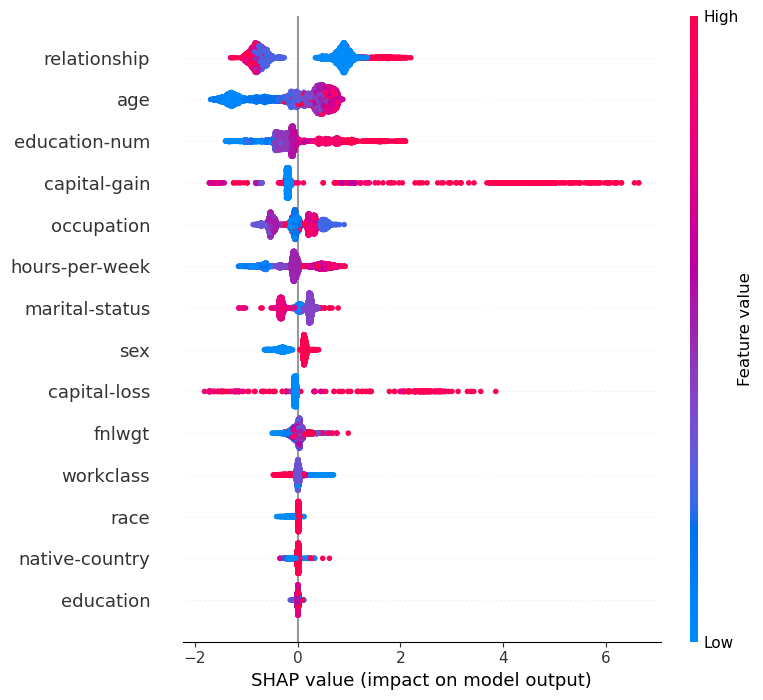

In [35]:
# Using SHAP


# ✅ Initialize the model
model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    min_samples_leaf=10,
    random_state=42
)
model.fit(X_train, y_train)
import shap

# Tree-based models only!
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot summary
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)


In [36]:
# threshold tuning
from sklearn.metrics import precision_recall_curve
import numpy as np

probs = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Find best F1 threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print("🔍 Best Threshold:", best_threshold)



🔍 Best Threshold: 0.4285997788944037


In [37]:
# Use the best threshold to make final predictions
final_preds = (probs > 0.428).astype(int)

# Evaluate again
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("✅ Accuracy (Custom Threshold):", accuracy_score(y_test, final_preds))
print(classification_report(y_test, final_preds))
print(confusion_matrix(y_test, final_preds))


✅ Accuracy (Custom Threshold): 0.872037129123156
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      4503
           1       0.76      0.72      0.74      1530

    accuracy                           0.87      6033
   macro avg       0.83      0.82      0.83      6033
weighted avg       0.87      0.87      0.87      6033

[[4159  344]
 [ 428 1102]]


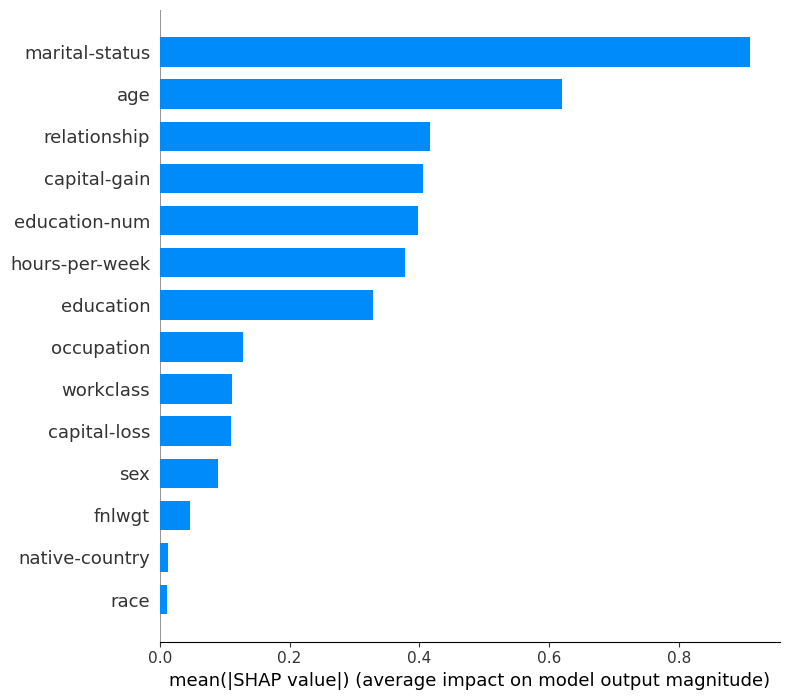

In [38]:
# shap dropping unimportant features
import shap
from sklearn.ensemble import GradientBoostingClassifier

# Train model
model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
model.fit(X_resampled, y_resampled)

# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Plot feature importance
shap.summary_plot(shap_values, X, plot_type="bar")


In [39]:
import numpy as np
import pandas as pd

# Calculate mean absolute SHAP value for each feature
shap_abs_mean = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': shap_abs_mean
}).sort_values(by='importance', ascending=False)

print(shap_importance)


           feature  importance
5   marital-status    0.910158
0              age    0.620013
7     relationship    0.416097
10    capital-gain    0.405113
4    education-num    0.397995
12  hours-per-week    0.377828
3        education    0.327935
6       occupation    0.128018
1        workclass    0.110453
11    capital-loss    0.109033
9              sex    0.089030
2           fnlwgt    0.045795
13  native-country    0.012129
8             race    0.010807


In [40]:
# Keep top N most important features
top_k = 10  # choose how many you want
top_features = shap_importance['feature'].head(top_k).tolist()

# Reduce X accordingly
X_top = X[top_features]


In [41]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Train again
model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_probs = model.predict_proba(X_test)[:, 1]
y_preds = (y_probs > 0.428).astype(int)  # use your threshold

from sklearn.metrics import accuracy_score, classification_report

print("Accuracy (retrained):", accuracy_score(y_test, y_preds))
print(classification_report(y_test, y_preds))


Accuracy (retrained): 0.8683905188131941
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      4503
           1       0.76      0.71      0.73      1530

    accuracy                           0.87      6033
   macro avg       0.83      0.82      0.82      6033
weighted avg       0.87      0.87      0.87      6033

